# Feature Importance Methods for Scientific Inference — SOLUTIONS

---

## Setup

Run all cells in this section first.

In [ ]:
!pip install git+https://github.com/gcskoenig/fippy.git -q
!pip install shap -q

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Per-observation squared error required by fippy for confidence interval computation
def square_error(y_true, y_pred):
    return (np.array(y_true) - np.array(y_pred)) ** 2

plt.rcParams.update({
    'font.size':        14,
    'axes.titlesize':   16,
    'axes.labelsize':   14,
    'xtick.labelsize':  13,
    'ytick.labelsize':  13,
})

### Data Generating Process

$$X_1 \sim \mathcal{N}(0,1), \quad X_3 \sim \mathcal{N}(0,1), \quad X_5 \sim \mathcal{N}(0,1) \quad \text{(mutually independent)}$$
$$X_2 = 0.999\,X_1 + \sqrt{1-0.999^2}\,\varepsilon_2, \qquad X_4 = 0.999\,X_3 + \sqrt{1-0.999^2}\,\varepsilon_4$$
$$Y = 5\,X_1 + \varepsilon_Y, \quad \varepsilon_Y \sim \mathcal{N}(0,1)$$

Only $X_1$ causes $Y$. $X_2$ is a noisy copy of $X_1$. $X_3$/$X_4$ are a correlated but irrelevant pair. $X_5$ is purely irrelevant.

In [27]:
def generate_data(n=1500, seed=83):
    rng = np.random.RandomState(seed)
    x1 = rng.normal(0, 1, n)
    x2 = 0.999 * x1 + np.sqrt(1 - 0.999**2) * rng.normal(0, 1, n)
    x3 = rng.normal(0, 1, n)
    x4 = 0.999 * x3 + np.sqrt(1 - 0.999**2) * rng.normal(0, 1, n)
    y  = 5 * x1 + rng.normal(0, 1, n)
    x5 = rng.normal(0, 1, n)
    X  = np.column_stack([x1, x2, x3, x4, x5])
    return X, y

X, y = generate_data()
feature_names = ["X1", "X2", "X3", "X4", "X5"]

### Model

OLS on 1000 training observations, evaluated on 500 test observations.

In [28]:
n_train = 1000
X_train, X_test = X[:n_train], X[n_train:]
y_train, y_test = y[:n_train], y[n_train:]

model = LinearRegression().fit(X_train, y_train)
print(f"Test R\u00b2: {model.score(X_test, y_test):.3f}")
print(f"Coefficients: {np.round(model.coef_, 2)}")

Test R²: 0.963
Coefficients: [ 3.11  1.88 -2.11  2.17  0.02]


### fippy setup

The **Gaussian sampler** estimates $P(X_j \mid X_{-j})$ in closed form under the multivariate normal assumption.

In [29]:
from fippy.explainers import Explainer
from fippy.samplers import GaussianSampler

X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df  = pd.DataFrame(X_test,  columns=feature_names)
y_train_s  = pd.Series(y_train, name='y')
y_test_s   = pd.Series(y_test,  name='y')

sampler   = GaussianSampler(X_train_df)
explainer = Explainer(model.predict, X_train_df,
                      loss=square_error, sampler=sampler)

---

# Solution 2: PFI — Implementation and Why It Misleads

**PFI** permutes feature $j$, breaking its association with all other variables, and measures the
resulting increase in loss:

$$\text{PFI}_j = \mathbb{E}[L(Y, \hat{f}(\tilde{X}_j, X_{-j}))] - \mathbb{E}[L(Y, \hat{f}(X))], \quad \tilde{X}_j \perp X_{-j}$$

PFI(X1): 21.1403
PFI(X2): 7.8702
PFI(X3): 7.6984
PFI(X4): 7.8738
PFI(X5): -0.0004


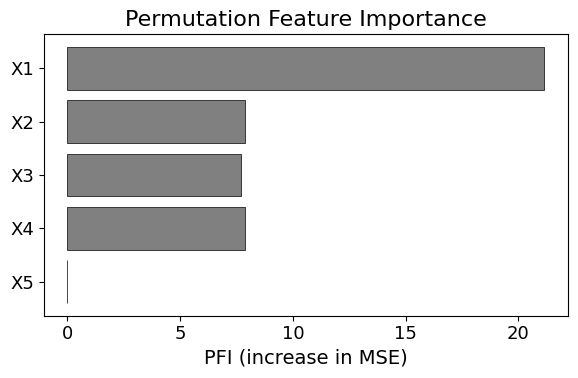

In [30]:
def my_pfi(model, X, y, feature_idx, n_repeats=50, seed=42):
    """Permutation Feature Importance for a single feature."""
    rng = np.random.RandomState(seed)
    baseline_mse = mean_squared_error(y, model.predict(X))

    perturbed_mses = []
    for _ in range(n_repeats):
        X_perm = X.copy()
        X_perm[:, feature_idx] = rng.permutation(X[:, feature_idx])
        perturbed_mses.append(mean_squared_error(y, model.predict(X_perm)))

    return np.mean(perturbed_mses) - baseline_mse


pfi_scores = [my_pfi(model, X_test, y_test, j) for j in range(len(feature_names))]
for name, score in zip(feature_names, pfi_scores):
    print(f"PFI({name}): {score:.4f}")

plt.figure(figsize=(6, 4))
plt.barh(feature_names[::-1], pfi_scores[::-1], color='grey', edgecolor='black', linewidth=0.5)
plt.xlabel("PFI (increase in MSE)")
plt.title("Permutation Feature Importance")
plt.tight_layout()
plt.show()

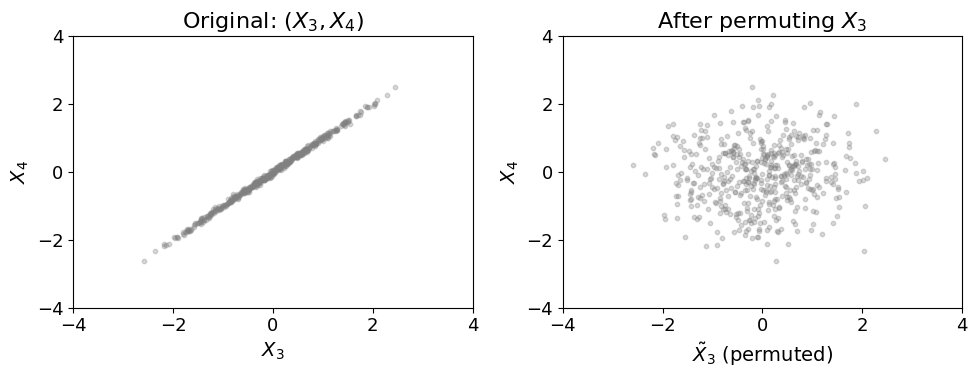

In [31]:
# Scatterplot: (X3, X4) before and after permuting X3
rng = np.random.RandomState(42)
X_perm = X_test.copy()
X_perm[:, 2] = rng.permutation(X_test[:, 2])

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(X_test[:, 2], X_test[:, 3], alpha=0.3, s=10, color='grey')
axes[0].set(xlabel="$X_3$", ylabel="$X_4$", title="Original: $(X_3, X_4)$",
            xlim=(-4,4), ylim=(-4,4))
axes[1].scatter(X_perm[:, 2], X_perm[:, 3], alpha=0.3, s=10, color='grey')
axes[1].set(xlabel=r"$\tilde{X}_3$ (permuted)", ylabel="$X_4$",
            title="After permuting $X_3$", xlim=(-4,4), ylim=(-4,4))
plt.tight_layout()
plt.show()

### Interpretation

**PFI values are high for all features except $X_5$** — including $X_3$ and $X_4$, which are
completely independent of $Y$.

**Why?** The fitted coefficients are $\hat{\beta} \approx [3.11, 1.88, -2.11, 2.17, 0.02]$.
Because $X_3 \approx X_4$ ($\rho = 0.999$), OLS assigns them large opposing coefficients that
nearly cancel in the original data. Permuting $X_3$ destroys this cancellation — the model's
predictions blow up, and PFI records a large error increase.

The scatterplot makes this visible: the original $(X_3, X_4)$ data lies on a tight diagonal.
After permuting $X_3$, the cloud becomes circular — these out-of-distribution combinations
never appeared during training.

**Key takeaway:** PFI measures *model reliance*, not association with $Y$.

| Conclusion | PFI $\neq$ 0 | PFI $= 0$ |
|---|---|---|
| Model uses feature | ✅ | ❓ |
| Feature is predictive of $Y$ | ❓ | ❓ |
| Feature is causally relevant | ❓ | ❓ |

---

# Solution 3: Conditional Feature Importance (CFI)

CFI replaces the permutation sampler with sampling from $P(X_j \mid X_{-j})$, preserving
the correlations between features while still breaking the direct $X_j$–$Y$ link:

$$\text{CFI}_j = \mathbb{E}[L(Y, \hat{f}(\tilde{X}_j, X_{-j}))] - \mathbb{E}[L(Y, \hat{f}(X))], \quad \tilde{X}_j \sim P(X_j \mid X_{-j})$$

The Gaussian sampler estimates this conditional distribution in closed form.

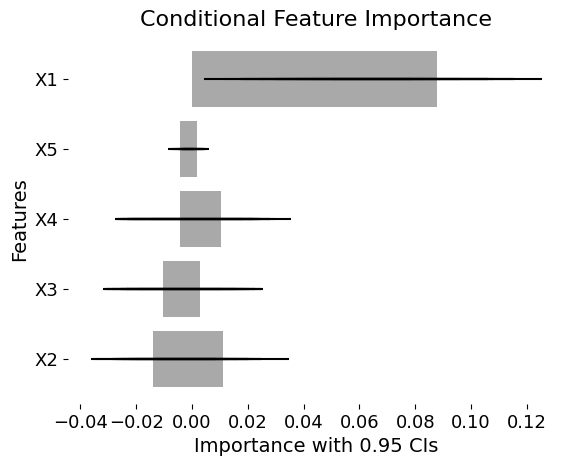

CFI scores:
  X1: 0.0644 ± 0.0145
  X2: -0.0032 ± 0.0075
  X3: -0.0034 ± 0.0043
  X4: 0.0009 ± 0.0042
  X5: -0.0009 ± 0.0020


In [32]:
ex_cfi = explainer.cfi(X_test_df, y_test_s, nr_runs=10)
ex_cfi.hbarplot()
plt.show()

scores_agg = ex_cfi.scores.groupby('sample').mean()
means = scores_agg.mean()
stds  = scores_agg.std()
print("CFI scores:")
for feat in feature_names:
    print(f"  {feat}: {means[feat]:.4f} ± {stds[feat]:.4f}")

### Interpretation

**Only $X_1$ receives a non-zero CFI score.** All others are $\approx 0$.

Why the conditional sampler fixes the problem:
- **$X_2$**: $\tilde{X}_2 \sim P(X_2 \mid X_1, X_3, X_4, X_5) \approx X_1$, so the model's
  prediction barely changes. CFI $\approx 0$ — $X_2$ carries no information about $Y$ *beyond
  what $X_1$ already provides*.
- **$X_3, X_4$**: $\tilde{X}_3 \sim P(X_3 \mid X_4, \ldots)$ preserves $\rho(X_3, X_4) = 0.999$,
  so the large opposing coefficients still cancel. CFI $\approx 0$ — they are irrelevant to $Y$.
- **$X_5$**: independent of everything; resampling changes nothing. CFI $\approx 0$.
- **$X_1$**: once $X_1$ is conditionally resampled, its strong direct effect on $Y$ is broken.
  CFI is large and positive.

**CFI $\neq 0$ implies conditional dependence:** $X_j \not\perp\!\!\!\perp Y \mid X_{-j}$.

| Conclusion | CFI $\neq$ 0 | CFI $= 0$ |
|---|---|---|
| Model uses feature | ✅ | ❓ |
| Pairwise association with $Y$ | ❓ | ❓ |
| Conditional association with $Y$ | ✅ | ❓ |

---

# Solution 4: Leave-One-Covariate-Out (LOCO)

LOCO measures the **drop in explained variance** when a feature is removed from the full model,
with the missing feature marginalised out via its conditional distribution:

$$\text{LOCO}_j = v(\{1,\ldots,p\}) - v(\{1,\ldots,p\} \setminus \{j\})$$

where the conditional SAGE value function is:

$$v(S) = \mathbb{E}[(Y - \mathbb{E}[f(X)])^2] - \mathbb{E}[(Y - \mathbb{E}[f(X)\mid X_S])^2]$$

$v(N) \approx \text{Var}(Y) \cdot R^2$, so expressing LOCO as a fraction of $v(N)$ gives
each feature's **share of the model's $R^2$**.

In [ ]:
N = feature_names

# v(N) on training and test data
ex_vN_train = explainer.csagevf(S=list(N), X_eval=X_train_df, y_eval=y_train_s)
v_N_train = float(ex_vN_train.scores.groupby('sample').mean().mean().iloc[0])
ex_vN_test  = explainer.csagevf(S=list(N), X_eval=X_test_df,  y_eval=y_test_s)
v_N_test  = float(ex_vN_test.scores.groupby('sample').mean().mean().iloc[0])
print(f"v(N) train = {v_N_train:.4f},  v(N) test = {v_N_test:.4f}\n")

# LOCO = v(N) - v(N\{j}) for every j; nr_runs repetitions to capture variability
ex_loco_train = explainer.csagevfs(X_train_df, y_train_s, C='remainder', nr_runs=10)
ex_loco_test  = explainer.csagevfs(X_test_df,  y_test_s,  C='remainder', nr_runs=10)

def loco_stats(ex_loco, v_N, label):
    agg   = ex_loco.scores.groupby('sample').mean()
    means, stds = agg.mean(), agg.std()
    print(f"LOCO ({label}):")
    for feat in feature_names:
        m, s = means[feat], stds[feat]
        print(f"  {feat}: {m:.4f} ± {s:.4f}  ({100 * m / v_N:.1f}%)")
    print()
    return means, stds

means_train, stds_train = loco_stats(ex_loco_train, v_N_train, "train")
means_test,  stds_test  = loco_stats(ex_loco_test,  v_N_test,  "test")

# Grouped horizontal bar plot (% of each split's explained variance)
pct_tr = [100 * means_train[f] / v_N_train for f in N]
pct_te = [100 * means_test[f]  / v_N_test  for f in N]
err_tr = [100 * stds_train[f]  / v_N_train for f in N]
err_te = [100 * stds_test[f]   / v_N_test  for f in N]

y_pos  = np.arange(len(N))
height = 0.35
fig, ax = plt.subplots(figsize=(7, 4))
ax.barh(y_pos + height/2, pct_tr[::-1], height, xerr=err_tr[::-1],
        label='Train', color='steelblue', edgecolor='black', linewidth=0.5,
        capsize=4, error_kw={'elinewidth': 1.5, 'capthick': 1.5})
ax.barh(y_pos - height/2, pct_te[::-1], height, xerr=err_te[::-1],
        label='Test',  color='grey',      edgecolor='black', linewidth=0.5,
        capsize=4, error_kw={'elinewidth': 1.5, 'capthick': 1.5})
ax.set_yticks(y_pos)
ax.set_yticklabels(N[::-1])
ax.axvline(0, color='black', linewidth=0.8)
ax.set_xlabel("Share of explained variance (%)")
ax.set_title("LOCO (conditional marginalization)")
ax.legend()
plt.tight_layout()
plt.show()

### Interpretation

**$X_1$ dominates on both splits**, accounting for essentially all of the model's explained
variance. The gap between the other features and zero is the interesting part.

#### Train vs. test discrepancy for noise features

OLS minimises training MSE, so even a feature that is completely unrelated to $Y$ can receive a
nonzero coefficient if it happens to correlate with the residuals in the training sample — this
is ordinary overfitting to noise.

- **On training data** the noise features ($X_3$, $X_4$, $X_5$, and partly $X_2$) show a small
  **positive** LOCO: the model learned to lean on them slightly, and on the data it was trained
  on, removing them (conditionally) does cause a tiny drop in explained variance.
- **On test data** those same features flip to a small **negative** LOCO. A negative value means
  that *marginalising the feature out actually improves performance* — the variance "explained"
  by that feature on unseen data is in fact spurious, and keeping it in the model adds noise
  rather than signal.

This train/test sign reversal is a direct signature of overfitting: the fitted reliance on a
noise feature is harmful on new data, so the model would predict better without it.

#### Per-feature summary

| Feature | Train LOCO | Test LOCO | Reason |
|---------|-----------|----------|--------|
| $X_1$ | large $+$ | large $+$ | True cause of $Y$; removing it collapses predictions |
| $X_2$ | $\approx 0$ | $\approx 0$ | Conditional on $X_1$, $X_2$ adds nothing ($\rho \approx 1$) |
| $X_3$ | small $+$ | small $-$ | Noise coefficient fit on train; harmful on test |
| $X_4$ | small $+$ | small $-$ | Same — correlated with $X_3$, opposing coefficient |
| $X_5$ | small $+$ | small $-$ | Tiny noise coefficient; marginally harmful on test |

#### Comparison with CFI

LOCO and CFI agree on *which* features matter ($X_1$ only), but LOCO adds two things CFI
does not:

1. **Interpretable magnitude** — the score directly equals the drop in explained variance, so
   it can be expressed as a fraction of $R^2$.
2. **Train/test comparison** — computing LOCO on both splits reveals overfitting in a
   feature-specific way: any feature whose test LOCO is negative was over-relied upon during
   training.

In [ ]:
import shap

# Use 100 random background samples for efficiency
background = shap.sample(X_train_df, 100, random_state=42)
shap_explainer = shap.KernelExplainer(model.predict, background)

shap_values_train = shap_explainer.shap_values(X_train_df)
shap_values_test  = shap_explainer.shap_values(X_test_df)

mean_abs_train = np.abs(shap_values_train).mean(axis=0)
mean_abs_test  = np.abs(shap_values_test).mean(axis=0)

print("Mean |SHAP| values:")
for name, tr, te in zip(feature_names, mean_abs_train, mean_abs_test):
    print(f"  {name}: train={tr:.4f}  test={te:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(11, 4), sharey=True)
for ax, vals, title in zip(axes,
                            [mean_abs_train, mean_abs_test],
                            ["KernelSHAP — Train", "KernelSHAP — Test"]):
    ax.barh(feature_names[::-1], vals[::-1], color='grey', edgecolor='black', linewidth=0.5)
    ax.set_xlabel("Mean |SHAP value|")
    ax.set_title(title)
axes[0].set_ylabel("Feature")
plt.tight_layout()
plt.show()

### Interpretation

#### Comparison with other methods

| Feature | PFI | CFI | LOCO | KernelSHAP |
|---------|-----|-----|------|------------|
| $X_1$ | large $+$ | large $+$ | large $+$ | large $+$ |
| $X_2$ | large $+$ | $\approx 0$ | $\approx 0$ | moderate $+$ |
| $X_3$ | large $+$ | $\approx 0$ | $\approx 0$ | moderate $+$ |
| $X_4$ | large $+$ | $\approx 0$ | $\approx 0$ | moderate $+$ |
| $X_5$ | $\approx 0$ | $\approx 0$ | $\approx 0$ | $\approx 0$ |

KernelSHAP falls **between PFI and CFI/LOCO**: it avoids PFI's extreme out-of-distribution
extrapolation, but because it replaces masked features with marginal background samples rather
than conditional ones, it still assigns non-zero importance to $X_2$, $X_3$, and $X_4$.

#### Why $X_2$, $X_3$, $X_4$ get credit

With marginal integration, masking $X_2$ replaces it with an independent sample — breaking its
near-perfect correlation with $X_1$. The model's coefficient on $X_2$ ($\hat{\beta}_2 \approx 1.88$)
then contributes visibly to prediction changes, so Shapley values credit $X_2$ directly.
The same logic applies to $X_3$/$X_4$: their large opposing coefficients ($-2.11$ / $+2.17$) are
no longer able to cancel when one is independently resampled, so both receive moderate importance.

#### Train vs. test

The train plot shows slightly inflated importance for $X_3$, $X_4$ — the same overfitting
signal seen in LOCO. On test data their mean $|\phi_j|$ is smaller, consistent with the finding
that the model's reliance on these features hurts out-of-sample performance.

**Key takeaway:** KernelSHAP (marginal) measures model reliance more fairly than PFI but
does not isolate conditional associations the way CFI and LOCO do. For scientific inference
about which features *matter for $Y$*, CFI and LOCO are more appropriate.

---

# Solution 5: Global Feature Importance with KernelSHAP

KernelSHAP estimates Shapley values by fitting a weighted linear model over random feature
coalitions. The background dataset determines how masked features are replaced — here we use
100 random training samples, so integration is **marginal** (not conditional).

$$\text{MeanSHAP}_j = \frac{1}{n}\sum_{i=1}^{n} |\phi_j^{(i)}|$$